# Dev notebook

To begin, we're using this dev notebook to develop and test new functionality. Here we have an interactive coding environment, a battery of 'tests', and examples below. All roled into one.

When things get more complicated we can break this out into an example notebook, and real pytests.

## Object Classes

copied from factum\lib\objects.py

In [1]:
from factum import DataFact, MindlessFact, Fact

## Examples

Here's one way to make an Fact. This is not the typical way, unless perhaps you wanted to create a fact type that has special functionality, such as might be the case in an ETL process where some nodes are extract nodes, others transform nodes, and others load nodes, and others still might even be visualize nodes, etc.

In [2]:
class A(Fact):
    def transform(self, **kw):
        print('A running!')
        return 1

In [3]:
a = A(name='Alpha')

None {}


In [4]:
a.name

'Alpha'

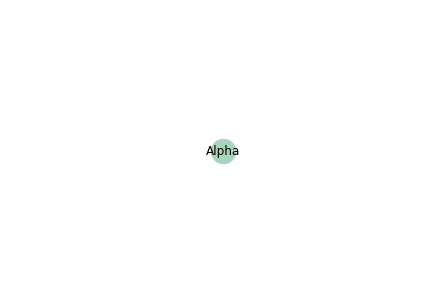

In [5]:
a.visualize()

In [6]:
a.inputs

{}

In [7]:
print(a.output)

None


lets tell the function to run by giving it one unit of gas.

In [8]:
a.run(1)

None
A running!


1

Since it remembers it's output if we give it a unit of gas again it will not run the function, it will just return the latest results

In [9]:
a.run(1)

1

Let's force it to run (if it has the gas to do so)

In [10]:
a.run(1, force=True)

None
A running!


1

In [11]:
print(a.output)

1


lets make another

In [12]:
class B(Fact):
    def transform(self, **kw):
        print('B running!')
        return 2

In [13]:
b = B(name='Beta')

None {}


lets actually no run it right now

In [14]:
# b.run()

In [15]:
print(b.output)

None


Lets make another, this time we wont make a whole new class, we'll use the class and attach a method to it

In [16]:
def c_transform(self, **kw):
    print('C running!')
    return self.kwargs['A'] + self.kwargs['B'] # doesn't work, object doesn't remember kwargs anymore

def c_transform_without_self(**kw):
    print('C running!')
    return kw['A'] + kw['B']

In [17]:
c = Fact(
    inputs={'A': a, 'B': b},
    transform=c_transform_without_self,  
    #transform=c_transform,  # also valid
)

# c.set_transform(c_transform)  # also valid

None {'A': <__main__.A object at 0x00000145371DB6A0>, 'B': <__main__.B object at 0x0000014557ED8B20>}


we didn't specify a name so the function name becomes it's name

In [18]:
c.transform.__name__

'c_transform_without_self'

In [19]:
c.name

'c_transform_without_self'

notice Alpha node is bigger than Beta node, that's because it has cached data

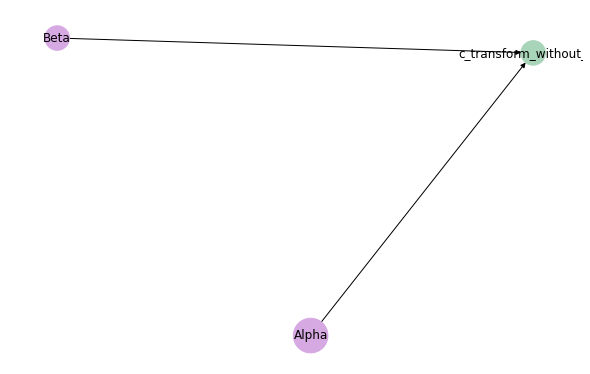

In [20]:
c.visualize()

Since we never ran B, C will realize we have to and will run it even though we didn't give it any gas

In [21]:
c.run()

None
None
B running!
C running!


3

lets run it again with -1 gas to indicate infinite gas, and forcing run of everything

In [22]:
c.run(-1)

None
C running!


3

In [23]:
c.run(1)

3

lets make another one, we can name inputs anything internally.

In [24]:
class D(Fact):
    def transform(self, **kw):
        print('D running!')
        return _layer_1(**kw)

In [25]:
d = D(inputs={'M': c})

None {'M': <factum.lib.objects.Fact object at 0x0000014557ED5070>}


since we didn't name it and didn't give it's transformation function a name it takes the name of the class

In [26]:
d.name

'D'

we can add methods to the instance that transform function can call

In [27]:
def _layer_1(**kw):
    return kw['M']+1
d.add_method(_layer_1)

root in question is green, parents are purple and ancestors are blue

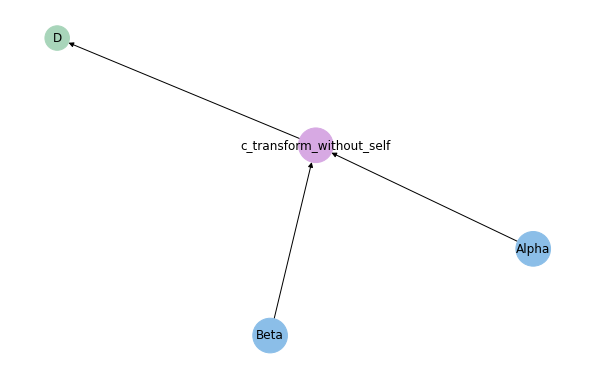

In [28]:
d.visualize()

lets run it, everything else has been cached already

In [29]:
d.run()

None
D running!


4

In [30]:
d.run(0)

4

In [31]:
d.run(1)

4

In [32]:
d.run(2, force=True)

None
None
C running!
D running!


4

In [33]:
d.run(3)

4

In [34]:
d.run(-1)

None
D running!


4

lets make one more

In [35]:
def transform(alpha_node, delta_node):
    print('E running!')
    return alpha_node + delta_node

notice we can define inputs as a list, a dictionary or a list and a dictionary in a tuple: this pattern denotes args and kwargs: ([], {})

In [36]:
e = Fact(
    inputs=([a], {'delta_node': d}),
    transform=transform,
    kind='Viz')

[<__main__.A object at 0x00000145371DB6A0>] {'delta_node': <__main__.D object at 0x0000014557ED5C70>}


we didn't give it a name, we didn't give transform a new name, we didn't give the class a new name, so it will make one up

In [37]:
e.name

'alzhmdmlpjub'

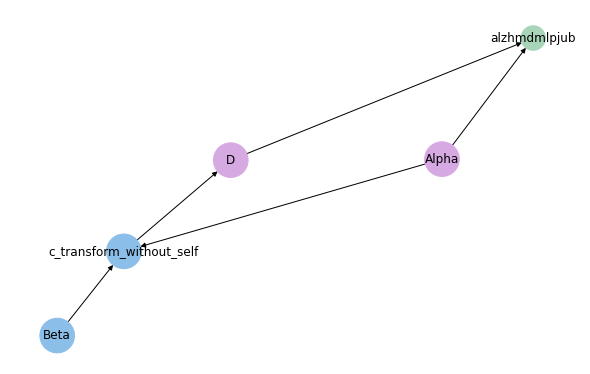

In [38]:
e.visualize()

In [39]:
e.run()

E running!


5

lets tell e to refresh it's dataset if a condition is met

In [40]:
e.run()

5

In [41]:
e.run(condition="self.kind == 'Viz'")

E running!


5

now lets run the whole dag and see that the Facts have names relative to the chain of those that called them last...

In [42]:
e.run(-1)

E running!


5

In [43]:
a.caller

'alzhmdmlpjub'

In [44]:
b.caller

'D.c_transform_without_self'

In [45]:
c.caller

'D'

In [46]:
d.caller

'alzhmdmlpjub'

In [47]:
e.caller

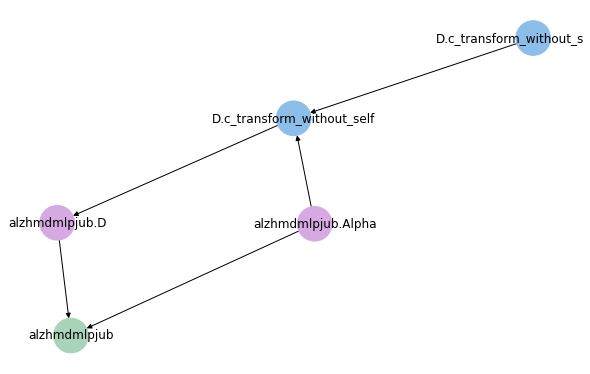

In [48]:
e.visualize(name_kind='tree_name')

## Concept Modeling Example

You may want to build a dag out of a nested directory structure. doing so allows one to model components or concepts of a system or business.

```
dag
├── basic_1
└── basic_2                       <- overarching name of concept
    ├── __init__.py
    │   └── def concetp_1         <- end of the dag
    └── detail_1                  <- subconcept name
        └── __init__.py
            ├── def extract       <- sub task within dag
            └── def transform     <- sub task within dag
            
# equivelant to: extract -> transform -> concept_1
concept_1(transform(extract()))
```

In [49]:
from factum.example import dag

In [50]:
extract = Fact(dag.basic_2.detail_1.extract)

None {}


In [51]:
transform = Fact(dag.basic_2.detail_1.transform, inputs={'e': extract})

None {'e': <factum.lib.objects.Fact object at 0x0000014559023490>}


In [52]:
load = Fact(dag.basic_2.concept_1, inputs={'t': transform})

None {'t': <factum.lib.objects.Fact object at 0x0000014559030310>}


In [53]:
extract.run()

None


'i am extract, anything can call me, but I have a unique address: factum.example.dag.basic_2.detail_1.extract, I also have a dag name depending on what the root node is: extract'

In [54]:
transform.run()

None


'I AM EXTRACT, ANYTHING CAN CALL ME, BUT I HAVE A UNIQUE ADDRESS: FACTUM.EXAMPLE.DAG.BASIC_2.DETAIL_1.EXTRACT, I ALSO HAVE A DAG NAME DEPENDING ON WHAT THE ROOT NODE IS: EXTRACT'

In [55]:
load.run(-1)

None
None


'I am extract, anything can call me, but i have a unique address: factum.example.dag.basic_2.detail_1.extract, i also have a dag name depending on what the root node is: extract'

# recursion

The following structure is a hash structure it contains one and only one loop. We can't use `gas=-1` because it will loop forever. This is fine in this case; we know they converge.

In [56]:
class X(Fact):
    def transform(self, **kw):
        if kw['Y'] < 10:
            i = kw['Y']+1
        else: 
            i = kw['Y']
        print(self.name, 'running! returning', i)
        return i
    
    
class Y(Fact):
    def transform(self, **kw):
        if kw['X'] < 6:
            i = kw['X']+1
        else: 
            i = kw['X']
        print(self.name, 'running! returning', i)
        return i
    
    
class Z(Fact):
    def transform(self, **kw):
        i = kw['Y']+1
        print(self.name, 'running! returning', i)
        return i

In [57]:
x = X(name='x')
y = Y(inputs={'X': x}, name='y')
z = Z(inputs={'Y': y}, name='z')
x.set_inputs(inputs={'Y': y})

None {}
None {'X': <__main__.X object at 0x000001455904DB20>}
None {'Y': <__main__.Y object at 0x000001455904DA90>}
None {'Y': <__main__.Y object at 0x000001455904DA90>}


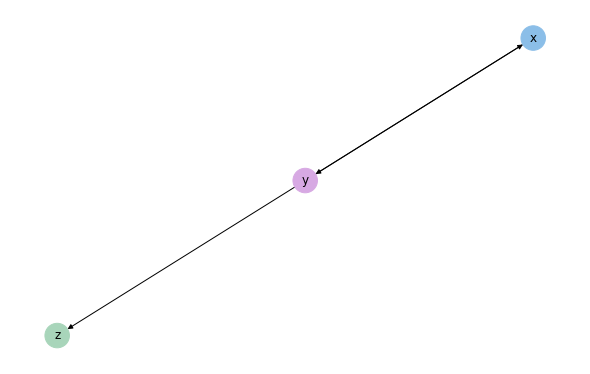

In [58]:
z.visualize()

notice, it counts up until X=6 then Y stops incrementing, but X continues to increment until it reaches 10, then, it still has gas left over so it continues to call each other until the gas runs out and the answer is returned to Z which runs it's own function that increments that answer by 1 and returns 11. 

This is a loop completely governed by gas, and the fact that one member of the loop was seeded with a default value. Since each function has internal state, being an object itself, loop behavior could be governed by internal counters, theoretically.

As you can see, creating a loop is difficult to manage and dangerous to execute. So it's best to make DAGs in general, but recursive relationships are possible. In fact, in an idealized parallel version of this design there would exist a main loop which runs forever, keeping the program alive.

In [59]:
import datetime as dt
x.output = 0
x.latest = dt.datetime.utcnow().timestamp()

In [60]:
z.run(20)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
y running! returning 1
x running! returning 2
y running! returning 3
x running! returning 4
y running! returning 5
x running! returning 6
y running! returning 6
x running! returning 7
y running! returning 7
x running! returning 8
y running! returning 8
x running! returning 9
y running! returning 9
x running! returning 10
y running! returning 10
x running! returning 10
y running! returning 10
x running! returning 10
y running! returning 10
z running! returning 11


11

in a recursive configuration we can see the full path in the tree_names as well

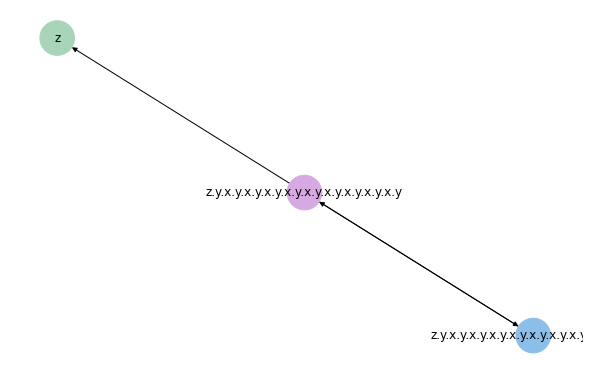

In [61]:
z.visualize(name_kind='tree_name', quick=True)